# Praca domowa 4 - Wstęp do Uczenia Maszynowego
## Maja Andrzejczuk i Julia Przybytniowska

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from scikitplot.estimators import plot_learning_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [50]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Korzystając z pracy domowej 3 przeprowadzimy preprocessing danych, aby modele oraz ich tuning były bardziej efektywne:
- sprawdzenie unikatowych wartości w kolumnach o zmiennych *int*, usunięcie niepotrzebnych
- zamiana wartości odstających (2,5%, 97,5%) na wartości w tych kwantylach
- zmiana kierunku korelacji na dodatni
- normalizacja zmiennych ciągłych przy użyciu MinMaxScaler()
- podział danych na zbiór treningowy i testowy

Przeprowadzimy to w jednej komórce ze względu na fakt że jest to powtórzenie kodu z wcześniejszego zadania.

In [51]:
#for col in df:
#  if len(df[col].unique()) < 100:
#    print(df[col].unique(), col)
#df[' Liability-Assets Flag'].value_counts()
#df[' Net Income Flag'].value_counts()
df.drop(columns = [' Liability-Assets Flag',' Net Income Flag'], inplace = True)
df_train,df_val = train_test_split(df,test_size=0.3, random_state=420, stratify=df['Bankrupt?'])

def outliers_to_quantiles(df):
    up_quantiles = df.quantile(0.975,axis=0)
    down_quantiles = df.quantile(0.025,axis=0)
    outliers_low = (df < down_quantiles)
    outliers_high = (df > up_quantiles)
    df_train = df.where(~outliers_low, down_quantiles, axis=1)
    df_train = df.where(~outliers_high, up_quantiles, axis=1)
    return df

def make_corr_positive(df):
  corrs = df.corrwith(df['Bankrupt?'])
  neg_corrs = np.where(corrs < 0)
  df.iloc[:,neg_corrs[0].tolist()] = -df.iloc[:,neg_corrs[0].tolist()]
  return df

def normalize_and_split(df):
  X = df.drop(columns = ['Bankrupt?'])  #zmienne opisujące, które będą normalizowane
  Y = df['Bankrupt?']                  #zmienna celu
  X = MinMaxScaler().fit_transform(X)
  return train_test_split(X, Y, test_size=0.3, random_state=420, stratify=Y)

df_train = outliers_to_quantiles(df_train)
df_train = make_corr_positive(df_train)
X_train, X_test, y_train, y_test= normalize_and_split(df_train)

#### Ograniczenie zmiennych przez zostawienie najważniejszych kolumn według  feature_importance modelu Random Forest

Na początku określamy liczbę drzew, następnie użyjemy funkcji *selectFromModel()* ze sklearn, aby automatycznie wybrać najważniejsze cechy.

In [52]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

Następnie tworzymy listę i liczymy wybrane przez nas cechy:

In [53]:
selected_feat= df_train.iloc[:,:-1].columns[(sel.get_support())]
len(selected_feat)

43

Sprawdzimy jakie zmienne wybraliśmy:

In [54]:
print(selected_feat)

Index(['Bankrupt?', ' ROA(A) before interest and % after tax',
       ' Operating Gross Margin', ' Operating Profit Rate',
       ' Pre-tax net Interest Rate', ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Research and development expense rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Operating Profit Per Share (Yuan ¥)',
       ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate',
       ' Net Value Growth Rate', ' Quick Ratio', ' Total debt/Total net worth',
       ' Debt ratio %', ' Long-term fund suitability ratio (A)',
       ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital', ' Revenue per person',
       ' Allocation rate per person', ' Working Capital to Total Assets',
       ' Current Assets/Total Assets', ' Operating Funds to Liability',
       ' Inventory/Current Liability', ' Current Liabilities/Liability',

Sprawdźmy rozłożenie "importance" na wykresie:

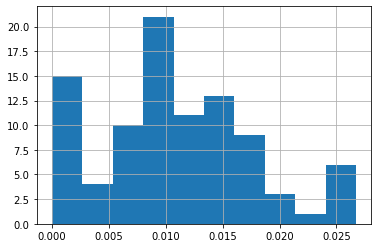

In [55]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [8]:
df_train = df_train[selected_feat]

In [9]:
X_train, X_test, y_train, y_test= normalize_and_split(df_train)

## Modele o domyślnych hiperparametrach:

In [10]:
def trainModel(model, X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)    
    predictions=model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions,average='micro')
    precision = precision_score(y_test, predictions,average='micro')
    f1 = f1_score(y_test, predictions, average='micro')
    auc = roc_auc_score(y_test,predictions)
    errorrate = 1 - accuracy_score(y_test, predictions)
    
    print('accuracy: ', accuracy)
    print('error rate', errorrate)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print('auc: ', auc)
    print('cross_validation: ',np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')))
    print(classification_report(y_test, predictions))
    
    plot_learning_curve(model, X_test, y_test, scoring='roc_auc');    
    plt.show()

### 1. Decision Tree

accuracy:  0.9615921787709497
error rate 0.03840782122905029
recall:  0.9615921787709497
precision:  0.9615921787709497
f1_micro:  0.9615921787709497
auc:  0.6754030993161427
cross_validation:  0.9485225976618192
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1386
           1       0.40      0.37      0.38        46

    accuracy                           0.96      1432
   macro avg       0.69      0.68      0.68      1432
weighted avg       0.96      0.96      0.96      1432



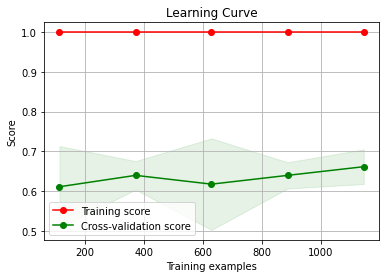

In [11]:
modelDT = DecisionTreeClassifier()

trainModel(modelDT, X_train, y_train, X_test, y_test)

### 2. Random Forest

accuracy:  0.9713687150837989
error rate 0.02863128491620115
recall:  0.9713687150837989
precision:  0.9713687150837989
f1_micro:  0.9713687150837989
auc:  0.5648566409435974
cross_validation:  0.9673777445109781
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.86      0.13      0.23        46

    accuracy                           0.97      1432
   macro avg       0.91      0.56      0.61      1432
weighted avg       0.97      0.97      0.96      1432



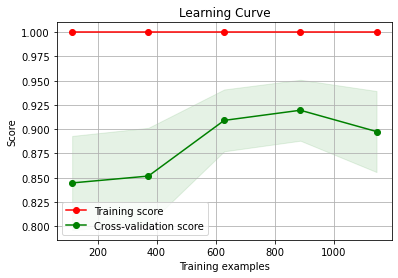

In [12]:
modelRF = RandomForestClassifier()

trainModel(modelRF, X_train, y_train, X_test, y_test)

### 3. SVC (Support Vector Machine)

accuracy:  0.9678770949720671
error rate 0.03212290502793291
recall:  0.9678770949720671
precision:  0.9678770949720671
f1_micro:  0.9678770949720671
auc:  0.5
cross_validation:  0.9676753635585971
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1386
           1       0.00      0.00      0.00        46

    accuracy                           0.97      1432
   macro avg       0.48      0.50      0.49      1432
weighted avg       0.94      0.97      0.95      1432



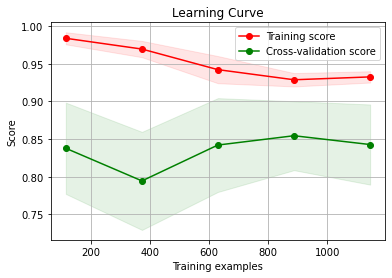

In [13]:
modelSVC = SVC()

trainModel(modelSVC, X_train, y_train, X_test, y_test)

## Tuning hiperparametrów każdego z modeli:

In [14]:
def gridSearch(model,grid, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
    result = grid_search.fit(X, y)
    print('Best score (gridSearch): %s' % result.best_score_)
    print('Best hyperparameters: %s' % result.best_params_)
    return

In [15]:
def randomSearch(model,grid, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    random_search = RandomizedSearchCV(estimator=model, param_distributions = grid, n_iter = 70, n_jobs=-1, cv=cv, scoring='accuracy', random_state=123)
    result = random_search.fit(X, y)
    print('Best score (randomSearch): %s' % result.best_score_)
    print('Best hyperparameters: %s' % result.best_params_)
    return 

### 1. Decision Tree

In [16]:
max_depth=[3,5,10,20]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
grid = {'max_features' : max_features,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'splitter': ['best', 'random'],
        "criterion": ["gini", "entropy"]}

In [17]:
gridSearch(modelDT, grid, X_train, y_train)

Best score (gridSearch): 0.9679736050287483
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'splitter': 'random'}


In [18]:
randomSearch(modelDT, grid, X_train, y_train)

Best score (randomSearch): 0.9680731075163105
Best hyperparameters: {'splitter': 'random', 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'gini'}


### 2. Random Forest

In [19]:
n_estimators = [50,100,200]
max_features = ['auto', 'sqrt']
max_depth = [10,20,40]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = dict(n_estimators=n_estimators,max_features= max_features,max_depth= max_depth,
            min_samples_leaf=min_samples_leaf,bootstrap= bootstrap)

In [20]:
gridSearch(modelRF, grid, X_train, y_train)

KeyboardInterrupt: 

In [ ]:
randomSearch(modelRF, grid, X_train, y_train)

### 3. SVC

In [ ]:
grid = {'C': [0.1, 10, 1000],
        'gamma': [1, 0.01, 0.0001],
        'kernel': ['rbf','poly', 'sigmoid']}

In [ ]:
gridSearch(modelSVC, grid, X_train, y_train)

In [ ]:
randomSearch(modelSVC, grid, X_train, y_train)

## Zobaczmy jak wyglądają wyniki metryk przed i po tuningu:

In [89]:
def compareModels(model,model_grid, model_random, X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)    
    predictions1=model.predict(X_test)
    model_grid.fit(X_train, y_train)    
    predictions2=model_grid.predict(X_test)
    model_random.fit(X_train, y_train)    
    predictions3=model_random.predict(X_test)
    
    accuracy = ["Accuracy", accuracy_score(y_test, predictions1), 
                accuracy_score(y_test, predictions2), 
                accuracy_score(y_test, predictions3)]
    errorrate = ["Error rate", 1-accuracy_score(y_test, predictions1),
                 1-accuracy_score(y_test, predictions2),
                1-accuracy_score(y_test, predictions3)]
    precision = ["Precision", precision_score(y_test, predictions1,average='micro'), 
                 precision_score(y_test, predictions2,average='micro'),
                 precision_score(y_test, predictions3,average='micro')]
    f1 = ["f1", f1_score(y_test, predictions1, average='micro'), 
          f1_score(y_test, predictions2, average='micro'),
          f1_score(y_test, predictions3, average='micro')]
    auc = ["AUC", roc_auc_score(y_test,predictions1),
           roc_auc_score(y_test,predictions2),
           roc_auc_score(y_test,predictions3)]
    cross_val = ["Cross Validation", 
                np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')), 
                np.mean(cross_val_score(model_grid, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')),
                np.mean(cross_val_score(model_random, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise'))]
    
    comparison=[accuracy, errorrate, precision, f1, auc, cross_val]
    return comparison

### 1. Decision Tree

In [ ]:
modelDTGrid = DecisionTreeClassifier(criterion= 'entropy',
                                   max_depth= 3,
                                   max_features= 'sqrt',
                                   min_samples_leaf= 2,
                                   splitter= 'random', random_state=123)
modelDTRandom= DecisionTreeClassifier(criterion= 'entropy',
                                   max_depth= 3,
                                   max_features= 'sqrt',
                                   min_samples_leaf= 4,
                                   splitter= 'random', random_state=123)
comparisonDT = compareModels(modelDT, modelDTGrid, modelDTRandom, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonDT, columns=["metric", "default_params", "gridSearch", "randomSearch"])

Widzimy, że accuracy, precision, f1 i cross validation zwiększyły wartości po optymalizacji za pomocą grid i random. AUC w obu przypadkach zmalało

### 2. Random Forest

In [ ]:
modelRFgrid = RandomForestClassifier(bootstrap= True,
                                     max_depth= 10,
                                     max_features= 'auto',
                                     min_samples_leaf= 2,
                                     n_estimators= 50)
modelRFrandom= RandomForestClassifier(bootstrap= True,
                                     max_depth= 10,
                                     max_features= 'auto',
                                     min_samples_leaf= 4,
                                     n_estimators= 200)
comparisonRF = compareModels(modelRF, modelRFgrid, modelRFrandom, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonRF, columns=["metric", "default_params", "gridSearch", "randomSearch"])

Zauważamy, że w przypadku RandomForest wartości metryk są najwyższe przy użyciu modelu z domyślnymi wartościami hiperparametrów 

### 3. SVC

In [ ]:
modelSVCgrid = SVC(C= 0.1,
                   gamma= 1,
                   kernel= 'rbf')
modelSVCrandom= SVC(C= 0.1,
                   gamma= 1,
                   kernel= 'rbf')
comparisonSVC = compareModels(modelSVC, modelSVCgrid, modelSVCrandom, X_train,y_train,X_test,y_test)
pd.DataFrame(comparisonSVC, columns=["metric", "default_params", "gridSearch", "randomSearch"])

W svc nie zmieniły się wartości naszych metryk, co oznacza ze hiperparametry domyślne są najlepsze.

### Podsumowanie
- Początkowo: sprawdziliśmy braki danych, typy zmiennych i ich unikalne wartości, zmieniłyśmy wartości odstające na wartości w odpowiednich kwantylach oraz kierunek korelacji na dodatni, znormalizowałyśmy zmienne ciągłe przy użyciu MinMaxScaler().
- Ograniczyłyśmy ilość zmiennych przez zostawienie najważniejszych kolumn według feature_importance modelu Random Forest.
- Jedynie w przypadku modelu DecisionTree optymalizacja z pomocą grid i random zwiększyła wartości naszych metryk.
- Najbardziej prosperującym modelem jest Random Forest z hiperparamtertami domyślnymi.

# Walidacja
#### Autorzy:
- Szymon Gut

- Jan Krężel


Wstępna faza preprocessingu na plus. Zespół budujący pamietał o zajęciu się outlierami, zadbał o poprawienie wartości wchodzących z ujemną korelacją oraz co najważniejsze zadbał o normalizacje MinMax. Jest to przydatne gdyż algorytm SVM dobrze radzi sobie z znormalizowanymi zmiennymi (z przedziału -1 : 1)

In [56]:
#skorzystajmy więc z tych funkcji na naszym zbiorze df_val
df_val = outliers_to_quantiles(df_val)
df_val = make_corr_positive(df_val)


Skorzystamy juz z wybranych featersow uzyskanych metoda selectFromModel, której użył zespół budujący


In [57]:
selected_feat

Index(['Bankrupt?', ' ROA(A) before interest and % after tax',
       ' Operating Gross Margin', ' Operating Profit Rate',
       ' Pre-tax net Interest Rate', ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Research and development expense rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Operating Profit Per Share (Yuan ¥)',
       ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate',
       ' Net Value Growth Rate', ' Quick Ratio', ' Total debt/Total net worth',
       ' Debt ratio %', ' Long-term fund suitability ratio (A)',
       ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital', ' Revenue per person',
       ' Allocation rate per person', ' Working Capital to Total Assets',
       ' Current Assets/Total Assets', ' Operating Funds to Liability',
       ' Inventory/Current Liability', ' Current Liabilities/Liability',

Bedziemy jednak chcieli wyprobowac rowniez PCA w celu znalezienia najistotniejszych cech i nastepnie porównamy wyniki z metodą SelectFromModel

In [58]:
len(sel.estimator_.feature_importances_.ravel())

93

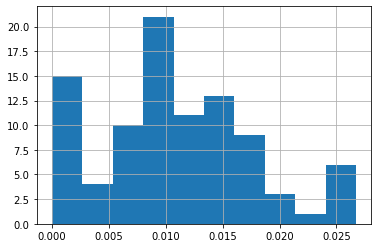

In [59]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [61]:
df_val = df_val[selected_feat]


In [63]:
X_val, X_test, y_val, y_test= normalize_and_split(df_train)

# Porównajmy wyniki 

zmodyfikujemy lekko funkcje zespołu budującego dodając do niej accuracy balanced, gdyż jak możemy pamiętać z hw3 nasz zbiór danych jest bardzo mocno nie zbalansowany jeśli chodzi o zmienna `bankruptcy`

In [94]:
from sklearn.metrics import balanced_accuracy_score

In [99]:
def compareModels_val(model,model_grid, model_random, X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)    
    predictions1=model.predict(X_test)
    model_grid.fit(X_train, y_train)    
    predictions2=model_grid.predict(X_test)
    model_random.fit(X_train, y_train)    
    predictions3=model_random.predict(X_test)
    
    accuracy = ["Accuracy", accuracy_score(y_test, predictions1), 
                accuracy_score(y_test, predictions2), 
                accuracy_score(y_test, predictions3)]
    errorrate = ["Error rate", 1-accuracy_score(y_test, predictions1),
                 1-accuracy_score(y_test, predictions2),
                1-accuracy_score(y_test, predictions3)]
    precision = ["Precision", precision_score(y_test, predictions1,average='micro'), 
                 precision_score(y_test, predictions2,average='micro'),
                 precision_score(y_test, predictions3,average='micro')]
    f1 = ["f1", f1_score(y_test, predictions1, average='micro'), 
          f1_score(y_test, predictions2, average='micro'),
          f1_score(y_test, predictions3, average='micro')]
    auc = ["AUC", roc_auc_score(y_test,predictions1),
           roc_auc_score(y_test,predictions2),
           roc_auc_score(y_test,predictions3)]
    balanced_accuracy = ["accuracy_balanced", balanced_accuracy_score(y_test, predictions1), 
          balanced_accuracy_score(y_test, predictions2),
          balanced_accuracy_score(y_test, predictions3)]
    cross_val = ["Cross Validation", 
                np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')), 
                np.mean(cross_val_score(model_grid, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise')),
                np.mean(cross_val_score(model_random, X_train, y_train, scoring='accuracy', cv=20, n_jobs=-1, error_score='raise'))]
    
    comparison=[accuracy, errorrate, precision, f1, auc, balanced_accuracy, cross_val]
    return comparison

## 1. Decision tree

accuracy:  0.9608938547486033
error rate 0.03910614525139666
recall:  0.9608938547486033
precision:  0.9608938547486033
f1_micro:  0.9608938547486033
auc:  0.6330070895288286
cross_validation:  0.9509160250926719
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1386
           1       0.36      0.28      0.32        46

    accuracy                           0.96      1432
   macro avg       0.67      0.63      0.65      1432
weighted avg       0.96      0.96      0.96      1432



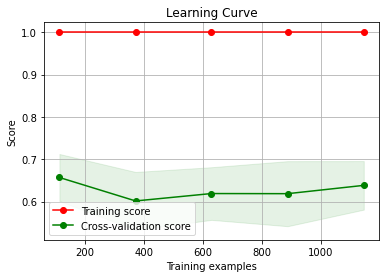

In [64]:
modelDT_val = DecisionTreeClassifier()

trainModel(modelDT_val, X_val, y_val, X_test, y_test)

### 2. Random Forest

accuracy:  0.9713687150837989
error rate 0.02863128491620115
recall:  0.9713687150837989
precision:  0.9713687150837989
f1_micro:  0.9713687150837989
auc:  0.5753654558002383
cross_validation:  0.9688711861990305
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.78      0.15      0.25        46

    accuracy                           0.97      1432
   macro avg       0.88      0.58      0.62      1432
weighted avg       0.97      0.97      0.96      1432



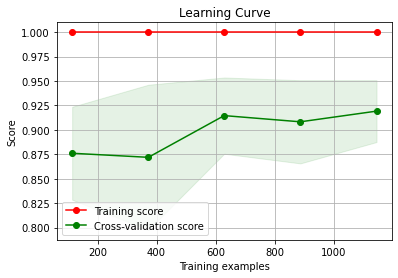

In [65]:
modelRF_val = RandomForestClassifier()

trainModel(modelRF_val, X_val, y_val, X_test, y_test)

### 3. SVC (Support Vector Machine)

accuracy:  0.9678770949720671
error rate 0.03212290502793291
recall:  0.9678770949720671
precision:  0.9678770949720671
f1_micro:  0.9678770949720671
auc:  0.5
cross_validation:  0.9676753635585971
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1386
           1       0.00      0.00      0.00        46

    accuracy                           0.97      1432
   macro avg       0.48      0.50      0.49      1432
weighted avg       0.94      0.97      0.95      1432



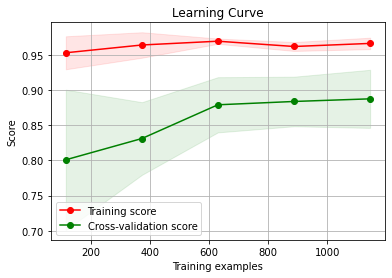

In [67]:
modelSVC_val = SVC()

trainModel(modelSVC_val, X_val, y_val, X_test, y_test)

Wykorzystamy funkcje zespołu budującego jednak lekko zmienimy parametry zawarte w slowniku `grid`

### 1. Decision tree

In [68]:
max_depth=[3,5,7]
max_features = ['auto', 'sqrt']
min_samples_leaf = [2, 4]
grid = {'max_features' : max_features,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'splitter': ['best', 'random'],
        "criterion": ["gini", "entropy"],
       ''}

In [69]:
gridSearch(modelDT_val, grid, X_val, y_val)

Best score (gridSearch): 0.9679736050287481
Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'splitter': 'random'}


Score praktycznie taki sam. Na 6 miejscu po przecinku dopiero zauważamy minimalny wzrost wydajności. Parametry wybrane wcześniej możemy zatem uznać za dobre.

In [70]:
randomSearch(modelDT_val, grid, X_val, y_val)

Best score (randomSearch): 0.9679733071171089
Best hyperparameters: {'splitter': 'random', 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy'}


### 2. Random Forest

In [71]:
n_estimators = [50,100,200]
max_features = ['auto', 'sqrt']
max_depth = [30,40,50]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]
grid = dict(n_estimators=n_estimators,max_features= max_features,max_depth= max_depth,
            min_samples_leaf=min_samples_leaf,bootstrap= bootstrap)

In [72]:
gridSearch(modelRF_val, grid, X_val, y_val)

Best score (gridSearch): 0.9690708135966872
Best hyperparameters: {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}


Uzyskany wynik jest minimalnie lepszy, niż ten uzyskany przez zespół budujący. Wcześniej score: 0.968 teraz 0.969

In [79]:
n_estimators = np.random.randint(50,200,20)
max_features = ['auto', 'sqrt']
max_depth = np.random.randint(30,50,5)
min_samples_leaf = np.random.randint(1,4,3)
bootstrap = [True, False]
grid = dict(n_estimators=n_estimators,max_features= max_features,max_depth= max_depth,
            min_samples_leaf=min_samples_leaf,bootstrap= bootstrap)

In [80]:
randomSearch(modelRF_val, grid, X_val, y_val)

Best score (randomSearch): 0.9688712127982839
Best hyperparameters: {'n_estimators': 138, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 38, 'bootstrap': True}


### 3. SVC

In [ ]:
from scipy.stats import uniform

In [84]:
grid = {'C': [0.1,0.5,1],
        'gamma': np.random.uniform(0.1,1,3),
        'kernel': ['rbf']}

In [85]:
gridSearch(modelSVC_val, grid, X_val, y_val)

Best score (gridSearch): 0.9676745017427828
Best hyperparameters: {'C': 0.1, 'gamma': 0.2990254335737369, 'kernel': 'rbf'}


In [86]:
grid = {'C': np.random.uniform(0.01,1,15),
        'gamma': np.random.uniform(0.001,1,20),
        'kernel': ['rbf']}

In [87]:
randomSearch(modelSVC_val, grid, X_val, y_val)

Best score (randomSearch): 0.9676745017427828
Best hyperparameters: {'kernel': 'rbf', 'gamma': 0.4707996248153804, 'C': 0.9862852145961778}


# Porównanie metryk po i przed tuningiem

### Decision Tree


In [100]:
modelDTGrid_val = DecisionTreeClassifier(criterion= 'gini',
                                   max_depth= 3,
                                   max_features= 'auto',
                                   min_samples_leaf= 2,
                                   splitter= 'random', random_state=123)
modelDTRandom_val = DecisionTreeClassifier(criterion= 'entropy',
                                   max_depth= 5,
                                   max_features= 'sqrt',
                                   min_samples_leaf= 2,
                                   splitter= 'random', random_state=123)
comparisonDT = compareModels_val(modelDT_val, modelDTGrid_val, modelDTRandom_val, X_val,y_val,X_test,y_test)
pd.DataFrame(comparisonDT, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.957402,0.969274,0.969274
1,Error rate,0.042598,0.030726,0.030726
2,Precision,0.957402,0.969274,0.969274
3,f1,0.957402,0.969274,0.969274
4,AUC,0.599677,0.521739,0.521739
5,accuracy_balanced,0.599677,0.521739,0.521739
6,Cross Validation,0.952114,0.967675,0.967376


### Random Forest

In [105]:
modelRFgrid_val = RandomForestClassifier(bootstrap= True,
                                     max_depth= 50,
                                     max_features= 'sqrt',
                                     min_samples_leaf= 3,
                                     n_estimators= 100)
modelRFrandom_val = RandomForestClassifier(bootstrap= True,
                                     max_depth= 38,
                                     max_features= 'auto',
                                     min_samples_leaf= 3,
                                     n_estimators= 138)
comparisonRF = compareModels_val(modelRF_val, modelRFgrid_val, modelRFrandom_val, X_val,y_val,X_test,y_test)
pd.DataFrame(comparisonRF, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.973464,0.972067,0.972765
1,Error rate,0.026536,0.027933,0.027235
2,Precision,0.973464,0.972067,0.972765
3,f1,0.973464,0.972067,0.972765
4,AUC,0.597465,0.575726,0.586596
5,accuracy_balanced,0.597465,0.575726,0.586596
6,Cross Validation,0.967378,0.967675,0.967376


### SVC

In [104]:
modelSVCgrid_val = SVC(C= 0.1,
                   gamma= 0.2990254335737369,
                   kernel= 'rbf')
modelSVCrandom_val = SVC(C= 0.9862852145961778,
                   gamma= 0.4707996248153804,
                   kernel= 'rbf')
comparisonSVC = compareModels_val(modelSVC_val, modelSVCgrid_val, modelSVCrandom_val, X_val,y_val,X_test,y_test)
pd.DataFrame(comparisonSVC, columns=["metric", "default_params", "gridSearch", "randomSearch"])

,metric,default_params,gridSearch,randomSearch
0,Accuracy,0.967877,0.967877,0.967877
1,Error rate,0.032123,0.032123,0.032123
2,Precision,0.967877,0.967877,0.967877
3,f1,0.967877,0.967877,0.967877
4,AUC,0.500000,0.500000,0.500000
5,accuracy_balanced,0.500000,0.500000,0.500000
6,Cross Validation,0.967675,0.967675,0.967675


Patrząc na accuracy możemy odnieść złudną nadzieje, że nasz model jest idealny. Warto jednak zwrócić uwagę na `accuracy_balanced_score` albo na `AUC`. Widzimy, że tutaj nasz model nie wypada już tak dobrze. Wynika to z faktu jak wyżej zostało wspomniane, że nasz zbiór danych jest bardzo mocno nie zbalansowany jeśli chodzi o zmienną celu `Bankruptcy`

Na sam koniec możemy dodać confusion matrix, żeby zobaczyć jak zachowują się nasze modele przy wyznaczaniu predykcji

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Decision Tree

### DT dla domyślnych parametrów

<function matplotlib.pyplot.show(*args, **kw)>

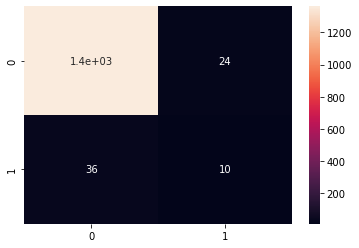

In [111]:
modelDT_val.fit(X_val, y_val)
y_pred = modelDT_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

### Grid Search

<function matplotlib.pyplot.show(*args, **kw)>

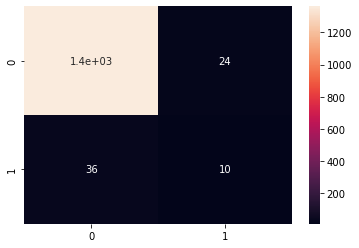

In [113]:
modelDTGrid_val.fit(X_val, y_val)
y_pred = modelDT_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

### Random Search

<function matplotlib.pyplot.show(*args, **kw)>

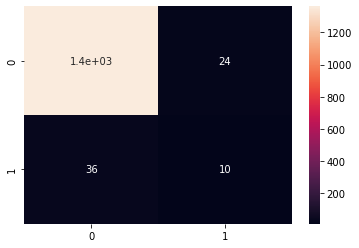

In [116]:
modelDTRandom_val.fit(X_val, y_val)
y_pred = modelDT_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

## Random Forest

### Parametry domyślne

<function matplotlib.pyplot.show(*args, **kw)>

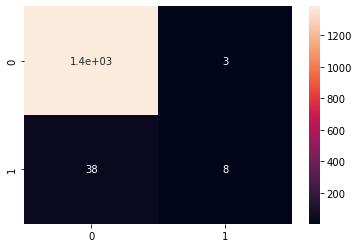

In [117]:
modelRF_val.fit(X_val, y_val)
y_pred = modelRF_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

### Grid Search

<function matplotlib.pyplot.show(*args, **kw)>

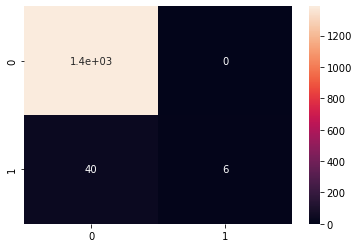

In [119]:
modelRFgrid_val.fit(X_val, y_val)
y_pred = modelRFrandom_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

### Random Search

<function matplotlib.pyplot.show(*args, **kw)>

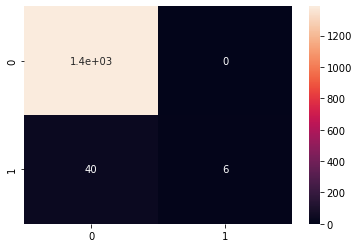

In [118]:
modelRFrandom_val.fit(X_val, y_val)
y_pred = modelRFrandom_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

## SVC

### Domyślne parametry

<function matplotlib.pyplot.show(*args, **kw)>

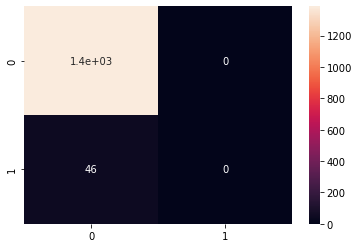

In [120]:
modelSVC_val.fit(X_val, y_val)
y_pred = modelSVC_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

### Grid Search

<function matplotlib.pyplot.show(*args, **kw)>

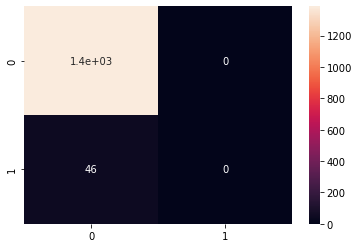

In [121]:
modelSVCgrid_val.fit(X_val, y_val)
y_pred = modelSVCgrid_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

### Random Search

<function matplotlib.pyplot.show(*args, **kw)>

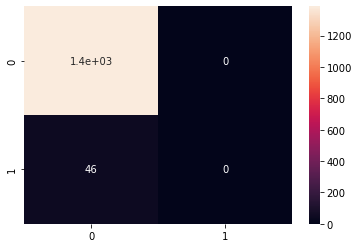

In [122]:
modelSVCrandom_val.fit(X_val, y_val)
y_pred = modelSVCrandom_val.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show

Jak się okazuje nasz dobór hiperparametrów również nie był do końca skuteczny. Tak samo jak zespołowi budującemu nie udało nam się zwiększyć score'a z wyjątkiem modelu DecisionTree. U nas także najlepszym modelem okazał się RandomForest.